## Minimum code for plotting aggregate codon/amino acid effects and comparison with published metrics
- (Figure 1)

In [40]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(ggh4x))
barcode_reads_cutoff <- 10 

### Global plotting themes

In [41]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(linewidth=0.2),
        axis.line.y=element_line(linewidth=0.2),
        axis.ticks.y =  element_line(linewidth=0.2),
        axis.ticks.x = element_line(linewidth=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

In [42]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

if (!file.exists('../tables')){
    dir.create('../tables')
}

### Load sample annotations and barcode counts

In [43]:
sample_annotations = read_csv("../annotations/sample_annotations.csv", comment='#')
sample_annotations

Rows: 2 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (3): barcode_read, barcode_start, barcode_length



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


owner,sample_type,sample_name,plasmid,library_type,illumina_sample_id,sample_id,barcode_read,barcode_start,barcode_length,linkage_ref,r1_file,r2_file,s3,shared
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kc,dicodon_yeast,wt_gdna,pHPSC1142,grna,51lib2,51lib2,1,1,24,yeast_cyto_linkage,kc_51lib2_S13_R1_001,kc_51lib2_S13_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/
kc,dicodon_yeast,wt_mrna,pHPSC1142,mrna,51lib1,51lib1,1,1,24,yeast_cyto_linkage,kc_51lib1_S12_R1_001,kc_51lib1_S12_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/


In [44]:
barcode_counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 197785 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 172594 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [45]:
head(barcode_counts)

barcode_count,insert_num,barcode_num,barcode,linkage_count,sample_name
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
NA,NA,1,barcode,NA,wt_gdna
4871,186,1643847,AGTCGTTGTAGCAACTCGATGTTT,16,wt_gdna
4653,5658,1596380,CTGGATGTCGCGAGCAACAACAGC,17,wt_gdna
3823,5810,764917,TGTATTCGGGCCAGCATGAGGTGC,4,wt_gdna
3656,2787,1040412,AGCGATTAGAGCATTTCTGGCCAC,3,wt_gdna
3577,203,1644177,TGGGATCTTTTCGCGTATTCGGTT,16,wt_gdna


### Load insert-barcode linkages

In [46]:
insert_barcode_linkages <- read_csv("../../8xdicodon_linkage/data/filtered_barcodes/yeast_cyto_linkage.csv") %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(linkage_count = as.numeric(linkage_count)) %>%
  mutate(linkage_ref = 'yeast_cyto_linkage')

head(insert_barcode_linkages)

Rows: 2455063 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


insert_num,barcode_num,barcode,linkage_count,linkage_ref
<dbl>,<dbl>,<chr>,<dbl>,<chr>
NA,1,barcode,NA,yeast_cyto_linkage
4457,2,GGGCTTAAGAAGATCCTTGTCAGG,99,yeast_cyto_linkage
4123,3,TAGCACATTTCCTCTGGGGTTCGT,99,yeast_cyto_linkage
4793,4,TACTGTTTTGCTCGTGGCGTTTAT,99,yeast_cyto_linkage
180,5,GAGAGGTGGATCGCGCACAGCAAG,99,yeast_cyto_linkage
4969,6,GGGGTGTATAGGACCGGCCAGTCT,99,yeast_cyto_linkage


In [47]:
barcode_insert_counts <- barcode_counts %>% 
  left_join(select(sample_annotations, c(sample_id, sample_name)), by = "sample_name") %>%
  left_join(insert_barcode_linkages, by = c("barcode_num", "barcode", "insert_num", "linkage_count")) %>%
  drop_na(barcode_count) %>%
  select(-sample_id)

head(barcode_insert_counts)

barcode_count,insert_num,barcode_num,barcode,linkage_count,sample_name,linkage_ref
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
4871,186,1643847,AGTCGTTGTAGCAACTCGATGTTT,16,wt_gdna,yeast_cyto_linkage
4653,5658,1596380,CTGGATGTCGCGAGCAACAACAGC,17,wt_gdna,yeast_cyto_linkage
3823,5810,764917,TGTATTCGGGCCAGCATGAGGTGC,4,wt_gdna,yeast_cyto_linkage
3656,2787,1040412,AGCGATTAGAGCATTTCTGGCCAC,3,wt_gdna,yeast_cyto_linkage
3577,203,1644177,TGGGATCTTTTCGCGTATTCGGTT,16,wt_gdna,yeast_cyto_linkage
3497,4868,692986,TCGCTCCGTGTCGTGTCTCCTATG,4,wt_gdna,yeast_cyto_linkage


In [48]:
if (!file.exists('../tables')){
    dir.create('../tables')
}

barcode_insert_counts %>%
    write_tsv("../tables/barcode_insert_counts.tsv.gz")

### Load insert annotations

In [49]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert) %>%
    print()

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,096 × 7
   insert_num dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          0 AAAAAA  KK    AAA    AAA    K     K    
 2          1 AAAAAC  KN    AAA    AAC    K     N    
 3          2 AAAAAG  KK    AAA    AAG    K     K    
 4          3 AAAAAT  KN    AAA    AAT    K     N    
 5          4 AAAACA  KT    AAA    ACA    K     T    
 6          5 AAAACC  KT    AAA    ACC    K     T    
 7          6 AAAACG  KT    AAA    ACG    K     T    
 8          7 AAAACT  KT    AAA    ACT    K     T    
 9          8 AAAAGA  KR    AAA    AGA    K     R    
10          9 AAAAGC  KS    AAA    AGC    K     S    
# … with 4,086 more rows


In [50]:
linkage <- insert_barcode_linkages %>% 
    inner_join(insert_annotations, by='insert_num') %>%
    mutate(library_type = 'plasmid') %>%
    select(insert_num, barcode_num, barcode, linkage_count, library_type) %>%
    filter(insert_num <= 4095) %>%
    dplyr::rename(count=linkage_count)

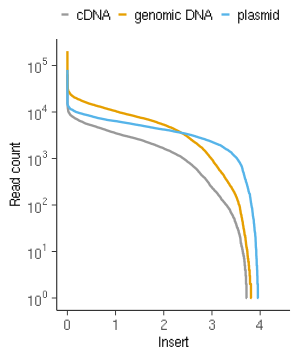

In [51]:
options(repr.plot.width = 2.5, repr.plot.height = 3)

barcode_insert_counts %>%
    filter(insert_num <= 4095) %>%
    mutate(library_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(library_type = ifelse(library_type == 'gdna', 'genomic DNA', 'cDNA')) %>%
    dplyr::rename(count=barcode_count) %>%
    select(insert_num, barcode_num, count, barcode, linkage_count, library_type) %>%
    bind_rows(linkage) %>%
    group_by(library_type, insert_num) %>%
    summarize(read_count = sum(count), .groups='drop') %>%
    group_by(library_type) %>%
    arrange(desc(read_count)) %>%
    mutate(xaxis = (1:dplyr::n())/1000) %>%
    ggplot() +
    aes(x=xaxis, y=read_count, color=library_type) +
    geom_line() +
    scale_y_log10(
    breaks = scales::trans_breaks("log10", function(x) 10^x),
    labels = scales::trans_format("log10", scales::math_format(10^.x))
    ) +
    scale_x_continuous(breaks = seq(0,4.5, 1), limits=c(0, 4.4)) +
    theme +
    theme(
        legend.position = "top",
        legend.justification='left',
        legend.key.width = unit(0.4, "line"),
        legend.box.margin=margin(-12,-12,-12,-12)) +
    labs(x='Insert', y='Read count', color='')

ggsave("../figures/cdf_reads_per_insert.pdf", width=2, height=2.15)

### Calculate basic stats for figure legend

In [70]:
linkage %>%
    filter(insert_num <= 4095) %>%
    group_by(insert_num) %>%
    summarize(n_barcodes=n(), .groups='drop') %>%
    dplyr::pull(n_barcodes) %>%
    median()

[1] 382

In [53]:
barcode_insert_counts %>%
    filter(insert_num <= 4095) %>%
    group_by(sample_name, insert_num) %>%
    summarize(n_barcodes = n(), .groups='drop') %>%
    group_by(sample_name) %>%
    summarize(med_barc = median(n_barcodes), .groups='drop')

sample_name,med_barc
<chr>,<dbl>
wt_gdna,27
wt_mrna,24


In [54]:
barcode_insert_counts %>%
    filter(insert_num <= 4095) %>%
    mutate(library_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(library_type = ifelse(library_type == 'gdna', 'genomic DNA', 'cDNA')) %>%
    group_by(library_type) %>%
    summarize(total_reads = sum(barcode_count), n_barcodes = n(), .groups='drop')

library_type,total_reads,n_barcodes
<chr>,<dbl>,<int>
cDNA,9163629,102200
genomic DNA,27083012,119006


In [55]:
barcode_insert_counts %>%
    filter(insert_num <= 4095) %>%
    mutate(library_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(library_type = ifelse(library_type == 'gdna', 'genomic DNA', 'cDNA')) %>%
    group_by(library_type, insert_num) %>%
    summarize(n_barcodes = n(),  .groups='drop') %>%
    group_by(library_type) %>%
    summarize(n_pairs = n(), .groups='drop') %>%
    mutate(n_pairs / 4096)

library_type,n_pairs,n_pairs/4096
<chr>,<int>,<dbl>
cDNA,3726,0.9096680
genomic DNA,3824,0.9335938


In [71]:
linkage %>%
    filter(insert_num <= 4095) %>%
    group_by(insert_num) %>%
    summarize(n_barcodes=n(), .groups='drop') %>%
    nrow() / 4096

[1] 0.9682617

### Plot aggregate effects for each codon

In [56]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$wt_mrna)) - log2(sum(d$wt_gdna))
}

In [57]:
barcode_insert_counts %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(codon1) %>%
  summarize(n_barc = n(), .groups='drop') %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-codon1, -n_barc)

barcode_insert_counts %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(codon2) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-codon2, -n_barc)

avg,med
<dbl>,<dbl>
1324.234,1225.5


avg,med
<dbl>,<dbl>
1324.234,1253


In [58]:
AMINO_ACID_CODE["*"] = "Stop"

codon1_lfc <- barcode_insert_counts %>%   
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(codon1) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 1) %>%
  rename(codon = codon1) %>%
  mutate(lfc_2 = lfc - median(lfc))

codon2_lfc <- barcode_insert_counts %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(codon2) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(pos = 2) %>%
  rename(codon = codon2) %>%
  mutate(lfc_2 = lfc - mean(lfc))

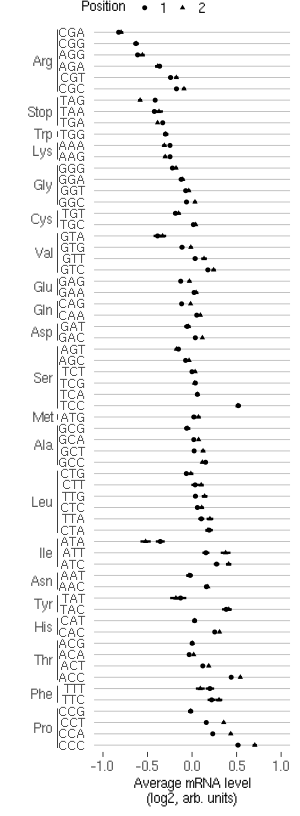

In [59]:
options(repr.plot.width = 2.5, repr.plot.height = 6.8)

aa_order <- c('Arg', 'Stop', 'Trp', 'Lys', 'Gly', 'Cys', 'Val', 'Glu', 'Gln', 'Asp', 'Ser', 'Met', 'Ala', 'Leu', 'Ile', 'Asn', 'Tyr', 'His', 'Thr', 'Phe', 'Pro')
AMINO_ACID_CODE["*"] = "Stop"

dicodon_plot_data <- bind_rows(codon1_lfc, codon2_lfc) %>%
  mutate(aa = AMINO_ACID_CODE[GENETIC_CODE[as.character(codon)]]) %>%
  arrange(factor(aa, levels = aa_order), lfc_2) %>%
  mutate(order_grp = 1:dplyr::n()) %>% 
  mutate(codon_2 = str_c(codon, ',', AMINO_ACID_CODE[GENETIC_CODE[as.character(codon)]])) %>%
  mutate(codon_2 = fct_reorder(codon_2, -order_grp))

dicodon_plot_data %>%
  ggplot(aes(x = lfc_2, y = codon_2, shape = as.factor(pos),
             xmin = lfc_2 - lfc_sd, xmax = lfc_2 + lfc_sd,
             )) +
  geom_errorbar(width=0, color = 'black') +
  geom_point(size=0.8) +
  scale_x_continuous(limits=c(-1.0, 1)) +
  scale_y_discrete(guide = guide_axis_nested(delim = ",")) +
  theme +
  theme(legend.position = "top",
        legend.justification='left',
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-10,-10,-10),
        legend.spacing.x = unit(0.25, 'mm'),
        panel.grid.major.y = element_line(color='grey', linewidth=0.2),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_text(size=7),
        ggh4x.axis.nesttext.y = element_text(size=8),
        ggh4x.axis.nestline = element_line(linewidth = 0.2),
        ) +
  labs(x = "Average mRNA level\n(log2, arb. units)", y = "",
       shape = "Position")

ggsave("../figures/fig1_bootstrapped_dicodon_effects_vertical.pdf", width=2.5, height=6.8)

### Plot aggregate effects of each amino acid

In [60]:
barcode_insert_counts %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(aa1) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-aa1, -n_barc)

barcode_insert_counts %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(aa2) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-aa2, -n_barc)

avg,med
<dbl>,<int>
4035.762,3647


avg,med
<dbl>,<int>
4035.762,3238


In [61]:
aa1_lfc <- barcode_insert_counts %>% 
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(aa1) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(pos = 1) %>%
  rename(aa = aa1)

aa2_lfc <- barcode_insert_counts %>%
  filter(barcode_count >= barcode_reads_cutoff) %>%
  pivot_wider(names_from = sample_name, values_from = barcode_count) %>% 
  drop_na() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(aa2) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(pos = 2) %>%
  rename(aa = aa2)

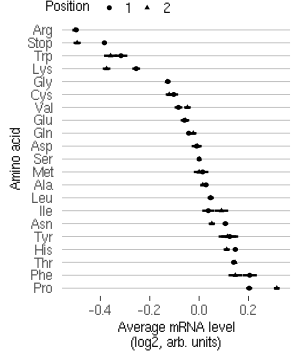

In [62]:
options(repr.plot.width=2.5, repr.plot.height=3)

AMINO_ACID_CODE["*"] = "Stop"

plot_data <- bind_rows(aa1_lfc, aa2_lfc) %>%
  group_by(aa) %>% 
  mutate(order = mean(lfc_med)) %>% 
  ungroup() %>% 
  mutate(aa = fct_reorder(AMINO_ACID_CODE[aa], -order)) %>% 
  select(-order)

plot_data %>%
  ggplot(aes(x = lfc_med, y = aa, shape = as.factor(pos),
             xmin = lfc_med - lfc_sd, xmax = lfc_med + lfc_sd,
             )) +
  geom_errorbar(width=0, color = 'black') +
  geom_point(size=0.8) +
  theme + 
  theme(legend.position = "top",
        legend.justification='left',
        legend.margin=margin(0,0,0,0),
        legend.box.margin=margin(-10,-12,-12,-12),
        legend.spacing.x = unit(0.25, 'mm'),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        ) +
  labs(x = "Average mRNA level\n(log2, arb. units)", y = "Amino acid",
       shape = "Position")

ggsave("../figures/fig1_bootstrapped_aa_effects.pdf", width=1.85, height=3)

### Fig 1D

In [63]:
sc_coller <- read_csv("../../../../data/literature/forrest_2020/table_s2_data.csv", skip=3) %>% 
    select('Codon', 'Amino_Acid', 'SC_CSC', 'SC_AASC')

csc_aasc_lfc <- sc_coller %>%
    inner_join(dicodon_plot_data, by=c('Codon' = 'codon'))

Rows: 61 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Codon, Amino_Acid, HEK293_IsOpt, HeLa_IsOpt
dbl (26): HEK293_tAI, HeLa_tAI_1, HeLa_tAI_2, HeLa_tAI_3, HeLa_Avg_tAI, HeLa...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


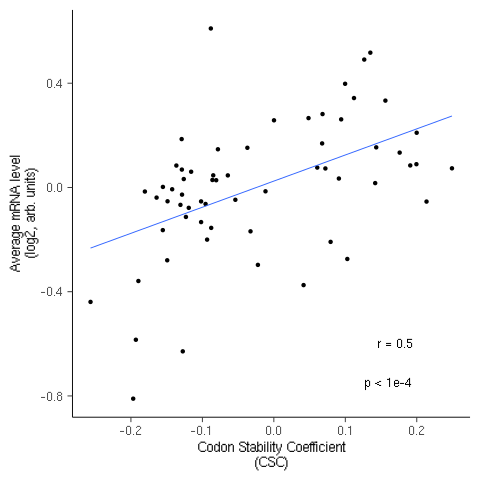

In [64]:
options(repr.plot.width=4, repr.plot.height=4)

plot_data <- csc_aasc_lfc %>%
    group_by(Codon) %>%
    mutate(avg_pos_lfc = mean(lfc_2)) %>%
    slice(1) %>%
    mutate(name = str_c(Codon, " (", GENETIC_CODE[Codon], ")"))

pearson_r = cor(plot_data$SC_CSC, plot_data$avg_pos_lfc, method=c('pearson'))
p = cor.test(plot_data$SC_CSC, plot_data$avg_pos_lfc, method=c('pearson'))$p.value

plot_data %>%
    ggplot() +
    aes(x=SC_CSC, y=avg_pos_lfc) +
    geom_point(size=0.2) + 
    geom_smooth(method=lm, size=0.2, se=FALSE) +
    annotate('text',x=0.17, y=-0.60, size=7/.pt, label=str_c("r = ", format(round(pearson_r, digits=2), nsmall = 2))) +
    annotate('text',x=0.16, y=-0.75, size=7/.pt, label="p < 1e-4") +
    theme +
    theme(axis.text.x=element_text(size=7),
          axis.text.y=element_text(size=7)) + 
    labs(x='Codon Stability Coefficient\n(CSC)', y='Average mRNA level\n(log2, arb. units)')

ggsave("../figures/fig1_avg_lfc_coller_csc_correlation_lm_dicodons.pdf", width=1.95, height=1.7, units='in', dpi=300)

In [66]:
p

[1] 5.260516e-05

### Fig 1E

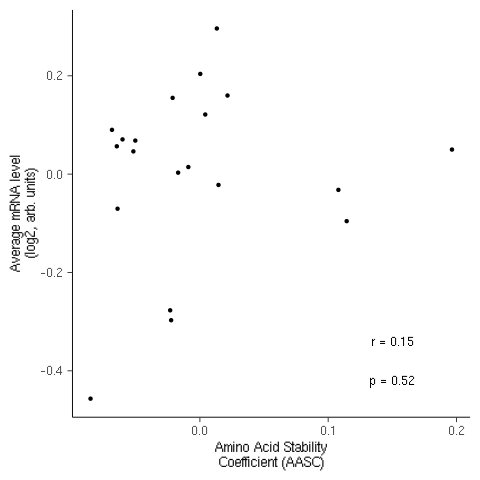

In [65]:
lfc_aasc <- csc_aasc_lfc %>%
    group_by(`Amino_Acid`) %>%
    summarize(avg_lfc = mean(lfc_2), .groups='drop') %>%
    left_join(select(csc_aasc_lfc, Amino_Acid, SC_AASC), by='Amino_Acid') %>%
    group_by(Amino_Acid) %>%
    slice(1)

pearson_r = cor(lfc_aasc$SC_AASC, lfc_aasc$avg_lfc, method=c('pearson'))
pearson_p = cor.test(lfc_aasc$SC_AASC, lfc_aasc$avg_lfc, method=c('pearson'))$p.value

lfc_aasc %>%
    ggplot() +
    aes(x=SC_AASC, y=avg_lfc) +
    geom_point(size=0.2) + 
    # geom_smooth(method=lm, size=0.2, se=FALSE) +
    theme +
    theme(axis.text.x=element_text(size=7),
          axis.text.y=element_text(size=7)) + 
    annotate('text',x=0.15, y=-0.34, size=7/.pt, label=str_c("r = ", round(pearson_r, 2))) +
    annotate('text',x=0.15, y=-0.42, size=7/.pt, label= str_c("p = ", round(pearson_p, 2))) +
    labs(x='Amino Acid Stability\nCoefficient (AASC)', y='Average mRNA level\n(log2, arb. units)')

ggsave("../figures/fig1_avg_amino_acid_lfc_vs_coller_aasc.pdf", width=1.95, height=1.7, units='in', dpi=300)